In [7]:
import os
import sys

In [9]:
sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
#sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')

In [10]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
c2p = Cell2PointsConverter(orders=[[3],[3,3]])

In [12]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [13]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(unrisky=True), method='sympy')

Number of equations: 11
Number of degrees of freedom: 28
Strictly stitched_power: 0
Start solving strict part
End solving strict part
NullspaceRank: 18


In [14]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [15]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=True),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [16]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=2)

In [21]:
opt_solve.restart_opt(tolerance=1e-3)

In [17]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [18]:
tr_f = np.vectorize(lambda x: (x-0.5)*x)

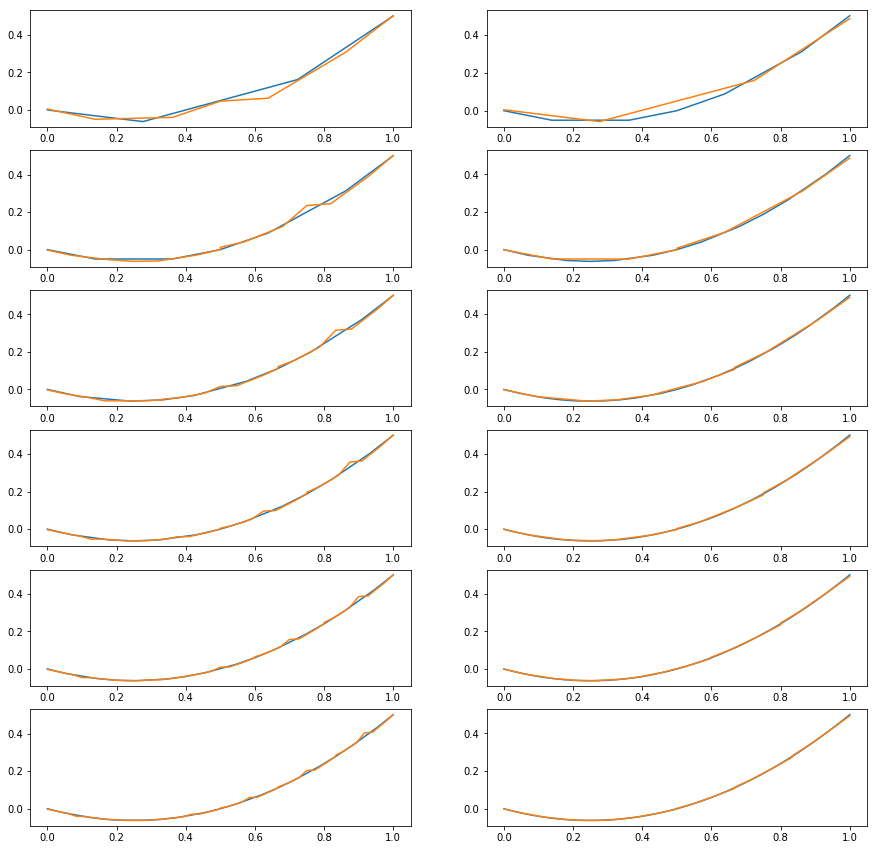

In [19]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

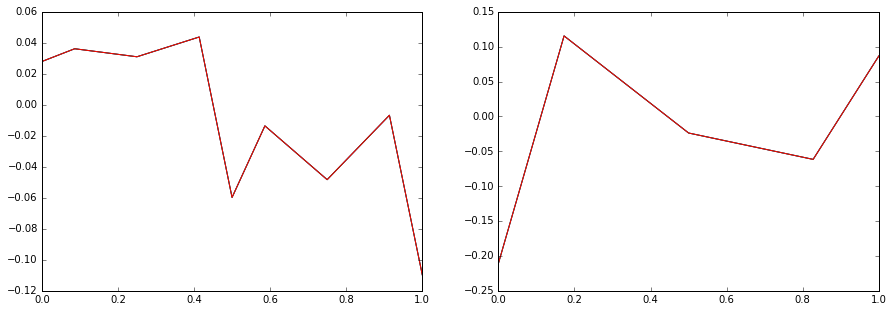

In [35]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [20]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

array([  9.12560781e-01 +0.00000000e+00j,
         9.48814959e-01 +0.00000000e+00j,
         9.99439959e-01 +0.00000000e+00j,
         1.00000000e+00 +0.00000000e+00j,
        -6.98092996e-17 +0.00000000e+00j,
         2.48424999e-17 +5.24131108e-17j,   2.48424999e-17 -5.24131108e-17j])

In [23]:
I_lr

array([[ 0.62584577,  0.74287624, -0.69579697,  0.32707497],
       [ 0.37035602,  0.71462439, -0.10993613,  0.02495572],
       [ 0.05668829,  0.63887521,  0.44998043, -0.14554393],
       [-0.13696959,  0.43779799,  0.81535681, -0.11618522],
       [-0.10971663,  0.36700592,  0.84584219, -0.10313148],
       [-0.14274098,  0.30368795,  0.27922416,  0.55982887],
       [ 0.77515993, -1.73943959,  1.7395301 ,  0.22474957]])

In [24]:
I_rl

array([[ 0.31292288,  0.92589005,  0.14172072, -0.13696959, -0.27429158,
        -0.35685246,  0.38757996],
       [ 0.07428762,  0.3573122 ,  0.3194376 ,  0.0875596 ,  0.18350296,
         0.15184398, -0.17394396],
       [-0.0695797 , -0.05496806,  0.22499022,  0.16307136,  0.42292109,
         0.13961208,  0.17395301],
       [ 0.16353748,  0.06238929, -0.36385983, -0.11618522, -0.2578287 ,
         1.39957218,  0.11237478]])

In [ ]:
np.dot(I_lr, c2p.get_weights()[0]).sum()

In [ ]:
c2p.get_weights()[0]

In [ ]:
np.dot(I_rl, c2p.get_weights()[1]).sum()

In [ ]:
np.dot(np.dot(c2p.get_diag_weights()[1], I_lr), np.linalg.inv(c2p.get_diag_weights()[0]))

In [ ]:
I_rl.T